In [1]:
import pandas as pd

# Project Imports
from notebooks.consts import *
from notebooks.preprocessing import preprocess_aso_data

# Correlation Analysis
from notebooks.utils.correlation_test import analyze_feature_correlations

# Pandas Display Settings
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', None)

In [2]:
# Load and preprocess the dataset
# This handles: Filtering Human, Dropping NaNs, Log Correction
all_data = preprocess_aso_data(UPDATED_CSV, include_smiles=False)

Preprocessing complete. Final valid rows: 29987


In [3]:
from tauso.features.modifications.populate import populate_modifications

all_data = populate_modifications(all_data, n_cores=None)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Calculating: Modification_fraction
Calculating: Modification_type_count
Calculating: Modification_5prime_run
Calculating: Modification_3prime_run
Calculating: Modification_min_distance_to_5prime
Calculating: Modification_min_distance_to_3prime
Calculating: Modification_pos_std
Calculating: Modification_block_count
Calculating: Modification_max_block_length
Calculating: Modification_char_entropy
Calculating: Modification_dominant_mod_fraction
Calculating: Modification_evenness
Calculating: Modification_symmetry_score
Calculating: Modification_skew_index
Calculating: Modification_mean_gap
Calculating: Modification_local_density_max
Calculating: Modification_in_core
Calculating: Modification_longest_repeat_run
Calculating: Modification_adjacent_pair_count
Calculating: Modification_strong_repeat_group_count


In [4]:
from tauso.features.modifications.populate import MODIFICATION_FEATURE_TO_CALCULATION
from notebooks.features.feature_extraction import save_feature
for feature in MODIFICATION_FEATURE_TO_CALCULATION.keys():
    save_feature(all_data, feature_name=feature)

File exists for 'Modification_fraction' but values are identical (within tolerance). No action taken.
File exists for 'Modification_type_count' but values are identical (within tolerance). No action taken.
File exists for 'Modification_5prime_run' but values are identical (within tolerance). No action taken.
File exists for 'Modification_3prime_run' but values are identical (within tolerance). No action taken.
File exists for 'Modification_min_distance_to_5prime' but values are identical (within tolerance). No action taken.
File exists for 'Modification_min_distance_to_3prime' but values are identical (within tolerance). No action taken.
File exists for 'Modification_pos_std' but values are identical (within tolerance). No action taken.
File exists for 'Modification_block_count' but values are identical (within tolerance). No action taken.
File exists for 'Modification_max_block_length' but values are identical (within tolerance). No action taken.
File exists for 'Modification_char_ent

In [5]:
from notebooks.utils.correlation_test import analyze_feature_correlations
results_df = analyze_feature_correlations(all_data, target='log_inhibition')
display(results_df)

/home/michael/career/tauso_article/tauso_source4/notebooks/utils/correlation_test.py:72: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(x, y)
/home/michael/career/tauso_article/tauso_source4/notebooks/utils/correlation_test.py:73: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(x, y)


,Feature,Pearson,Spearman,NMI_max
15,Inhibition(%),0.891,1.000,2.042
1,ISIS,-0.051,-0.129,0.152
0,index,0.340,0.325,0.114
20,Location_in_sequence,-0.022,0.204,0.108
26,sense_start,-0.027,0.199,0.108
6,ASO_volume(nM),0.305,0.325,0.093
34,Modification_pos_std,-0.228,-0.194,0.053
42,Modification_mean_gap,-0.275,-0.258,0.047
21,Location_div_by_length,0.056,0.103,0.045
46,Modification_adjacent_pair_count,0.111,0.092,0.038


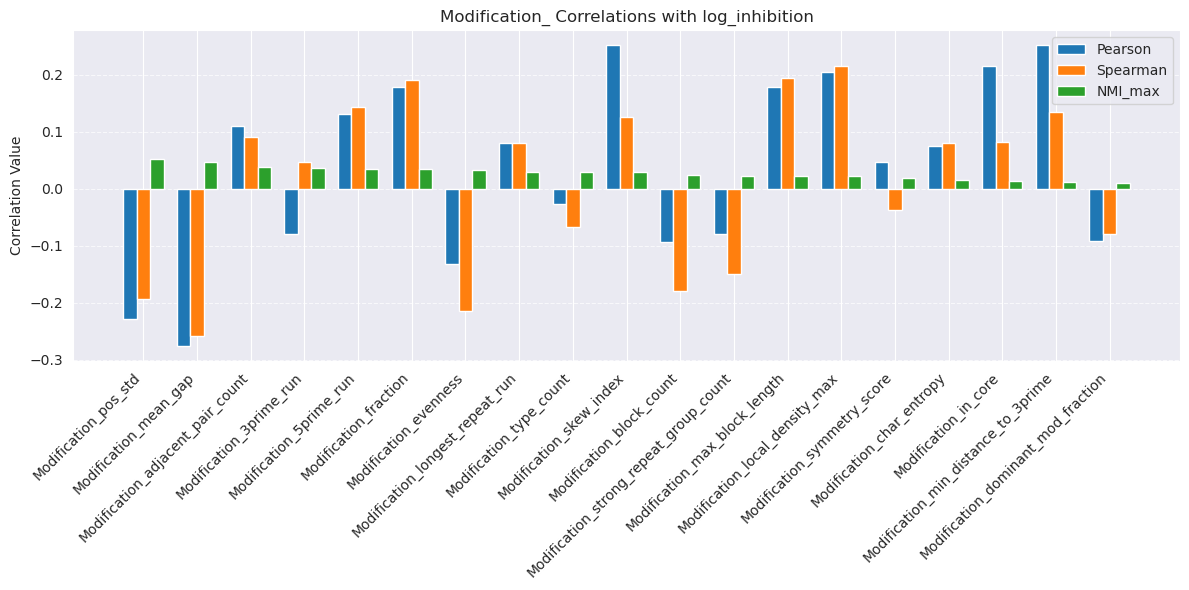

In [6]:
from notebooks.utils.correlation_test import plot_feature_correlations_by_prefix
plot_feature_correlations_by_prefix(results_df, prefix='Modification_', title='Modification_ Correlations with log_inhibition')